In [101]:
#importing deps
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from random import seed
from random import randrange
from random import random
from math import exp
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [84]:
# Load the dataset from the CSV file
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
banknote_df = pd.read_csv(url, header=None)


In [85]:
banknote_df.shape

(1372, 5)

In [86]:
# Split a dataset into k folds
def cross_validation_split(df, n_folds):
    df_split = list()
    df_copy = df.copy()
    fold_size = int(len(df) / n_folds)
    for i in range(n_folds):
        fold = df_copy.sample(n=fold_size, replace=False)
        df_copy = df_copy.drop(fold.index)
        df_split.append(fold)
    return df_split

In [87]:
# Calculate accuracy percentage
def accuracy_met(actual, predicted):
    # Convert input lists to Pandas Series for easy comparison
    actual_series = pd.Series(actual)
    predicted_series = pd.Series(predicted)

    # Count the number of correct predictions
    correct = (actual_series == predicted_series).sum()

    # Calculate and return the accuracy as a percentage
    accuracy = (correct / len(actual)) * 100.0
    return accuracy

In [88]:
def run_algorithm(dataset, algorithm, n_folds, *args):
    # Define a function to calculate accuracy percentage

    # Split the dataset into cross-validation folds
    folds = cross_validation_split(dataset, n_folds)

    # Initialize a list to store accuracy scores for each fold
    scores = list()

    for i in range(n_folds):
        # Extract the test set for this fold
        test_set = folds[i]

        # Combine all other folds to form the training set
        train_folds = [f for j, f in enumerate(folds) if j != i]
        train_set = pd.concat(train_folds)

        # Extract the actual target values for the test set
        actual = test_set.iloc[:, -1].tolist()

        # Make a copy of the test set and remove the target column for predictions
        test_set_copy = test_set.copy()
        test_set_copy.iloc[:, -1] = None
        
        print(f"For Fold {i+1}:")

        # Make predictions using the algorithm (function) with given arguments
        predicted = algorithm(train_set, test_set_copy, *args)
        
        accuracy = accuracy_met(actual, predicted)
        cm = confusion_matrix(actual, predicted)
        
        print("Confusion Matrix:")
        print(cm)

        FP = cm.sum(axis=0) - np.diag(cm)
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        TPR = TP / (TP + FN)
        TNR = TN / (TN + FP)
        Precision = TP / (TP + FP)
        Recall = TP / (TP + FN)
        Acc = (TP + TN) / (TP + TN + FP + FN)
        Fscore = 2 * (Precision * Recall) / (Precision + Recall)
        k = cohen_kappa_score(actual, predicted)

        print(f"False Positives: {FP}")
        print(f"False Negatives: {FN}")
        print(f"True Positives: {TP}")
        print(f"True Negatives: {TN}")
        print(f"Sensitivity (True Positive Rate): {TPR}")
        print(f"Specificity (True Negative Rate): {TNR}")
        print(f"Precision: {Precision}")
        print(f"Recall: {Recall}")
        print(f"Accuracy: {Acc}")
        print(f"F1 Score: {Fscore}")
        print(f"Cohen's Kappa: {k}")

        scores.append(accuracy)
        print('\n\n')

    return scores

In [89]:
# Calculate neuron activation for an input
def activate(weights, inputs):
    # Add bias weight to the inputs
    inputs_with_bias = inputs + [weights[-1]]

    # Convert the weights and inputs to Pandas Series for element-wise multiplication
    weights_series = pd.Series(weights[:-1])  # Exclude the bias weight
    inputs_series = pd.Series(inputs_with_bias)

    # Calculate the activation using element-wise multiplication and sum
    activation = (weights_series * inputs_series).sum()

    return activation

In [90]:
#Softmax Activation function
def softmax(logits):
    # Compute the exponential of each element in the logits array
    exp_logits = np.exp(logits)

    # Calculate the sum of exponential logits for normalization
    sum_exp_logits = np.sum(exp_logits)

    # Calculate the softmax probabilities for each class
    softmax_probs = exp_logits / sum_exp_logits

    return softmax_probs


In [91]:
# Forward propagate input to a network output
def forward_propagate(network, row):
    inputs = row

    for layer in network:
        new_inputs = []
        neuron_net= []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron_net.append(activation)
        new_inputs= softmax(neuron_net)
        for i, neuron in enumerate(layer):
            neuron['output']= new_inputs[i]
        inputs = new_inputs
    return inputs

In [92]:
def loss(network,expected):
    layer= network[len(network)-1] #getting output layer
    loss=[]
    for i, neuron in enumerate(layer):
        loss.append(expected[i] * np.log(neuron['output']))
    return -sum(loss)

In [93]:
# Calculate the derivative of an neuron output
def transfer_derivative(output):
        return output * (1.0 - output)

In [94]:
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
        for i in reversed(range(len(network))):
                layer = network[i]
                errors = list()
                if i != len(network)-1: #if not output layer
                        for j in range(len(layer)):
                                error = 0.0
                                for neuron in network[i + 1]:
                                        error += (neuron['weights'][j] * neuron['delta'])
                                errors.append(error)
                else: #for output layer
                        for j in range(len(layer)):
                                neuron = layer[j]
                                errors.append(expected[j] - neuron['output'])
                for j in range(len(layer)):
                        neuron = layer[j]
                        neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

In [95]:
# Update network weights with error
def update_weights(network, row, l_rate):
        for i in range(len(network)):
                inputs = row[:-1]                
                if i != 0: #if not input layer
                        inputs = [neuron['output'] for neuron in network[i - 1]]
                for neuron in network[i]:
                        for j in range(len(inputs)):
                                temp = l_rate * neuron['delta'] * inputs[j] + mu * neuron['prev'][j]
                                
                                neuron['weights'][j] += temp
                                neuron['prev'][j] = temp
                        temp = l_rate * neuron['delta'] + mu * neuron['prev'][-1]
                        neuron['weights'][-1] += temp
                        neuron['prev'][-1] = temp

In [104]:
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    Total_losses=[]
    for epoch in range(n_epoch):
        loss_agr= []
        i=0
        for _, row in train.iterrows():
            outputs = forward_propagate(network, row.iloc[:4].values.tolist())
            expected = [0 for i in range(n_outputs)]
            expected[int(row[4])] = 1
            loss_agr.append(loss(network,expected))
            backward_propagate_error(network, expected)
            update_weights(network, row.values.tolist(), l_rate)
            i+=1
        Total_losses.append(sum(loss_agr)/i)
    
    index_range = range(len(Total_losses))
    plt.plot(index_range, Total_losses)
    plt.xlabel('epoch')
    plt.ylabel('Loss Mean')
    plt.title('Plot between epoch and Loss')
    plt.xticks(index_range)
    plt.show()







    

In [97]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
        network = list()
        hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)], 'prev':[0 for i in range(n_inputs+1)]} for i in range(n_hidden)]        
        network.append(hidden_layer)
        output_layer = [{'weights':[random() for i in range(n_hidden + 1)],'prev':[0 for i in range(n_hidden+1)]} for i in range(n_outputs)]
        network.append(output_layer)
        return network

In [98]:
# Make a prediction with a network
def predict(network, row):
        outputs = forward_propagate(network, row)
        return np.argmax(outputs)

In [99]:
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
        n_inputs = train.shape[1] - 1
        n_outputs = len(set([value for value in train.iloc[:, -1]]))
        network = initialize_network(n_inputs, n_hidden, n_outputs)
        train_network(network, train, l_rate, n_epoch, n_outputs)
        predictions = list()
        for _, row in test.iterrows():
                prediction = predict(network, row.iloc[:4].values.tolist())
                predictions.append(prediction)
        return(predictions)

For Fold 1:


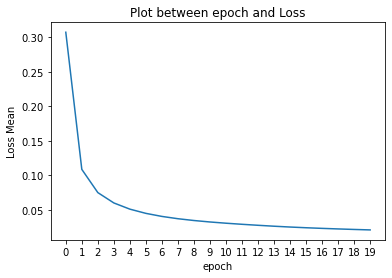

Confusion Matrix:
[[158   0]
 [  0 116]]
False Positives: [0 0]
False Negatives: [0 0]
True Positives: [158 116]
True Negatives: [116 158]
Sensitivity (True Positive Rate): [1. 1.]
Specificity (True Negative Rate): [1. 1.]
Precision: [1. 1.]
Recall: [1. 1.]
Accuracy: [1. 1.]
F1 Score: [1. 1.]
Cohen's Kappa: 1.0



For Fold 2:


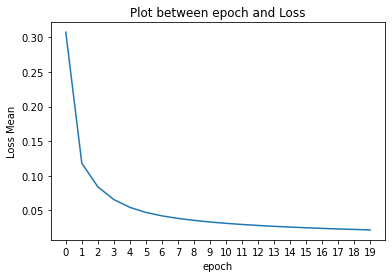

Confusion Matrix:
[[152   0]
 [  0 122]]
False Positives: [0 0]
False Negatives: [0 0]
True Positives: [152 122]
True Negatives: [122 152]
Sensitivity (True Positive Rate): [1. 1.]
Specificity (True Negative Rate): [1. 1.]
Precision: [1. 1.]
Recall: [1. 1.]
Accuracy: [1. 1.]
F1 Score: [1. 1.]
Cohen's Kappa: 1.0



For Fold 3:


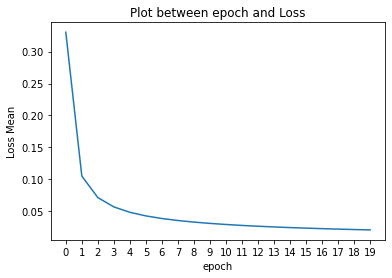

Confusion Matrix:
[[147   0]
 [  0 127]]
False Positives: [0 0]
False Negatives: [0 0]
True Positives: [147 127]
True Negatives: [127 147]
Sensitivity (True Positive Rate): [1. 1.]
Specificity (True Negative Rate): [1. 1.]
Precision: [1. 1.]
Recall: [1. 1.]
Accuracy: [1. 1.]
F1 Score: [1. 1.]
Cohen's Kappa: 1.0



For Fold 4:


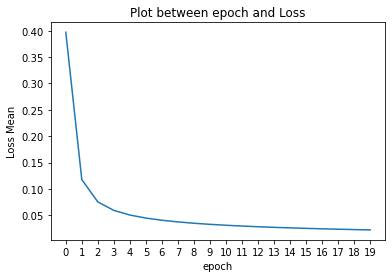

Confusion Matrix:
[[144   0]
 [  0 130]]
False Positives: [0 0]
False Negatives: [0 0]
True Positives: [144 130]
True Negatives: [130 144]
Sensitivity (True Positive Rate): [1. 1.]
Specificity (True Negative Rate): [1. 1.]
Precision: [1. 1.]
Recall: [1. 1.]
Accuracy: [1. 1.]
F1 Score: [1. 1.]
Cohen's Kappa: 1.0



For Fold 5:


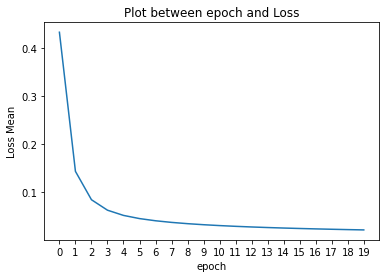

Confusion Matrix:
[[159   0]
 [  0 115]]
False Positives: [0 0]
False Negatives: [0 0]
True Positives: [159 115]
True Negatives: [115 159]
Sensitivity (True Positive Rate): [1. 1.]
Specificity (True Negative Rate): [1. 1.]
Precision: [1. 1.]
Recall: [1. 1.]
Accuracy: [1. 1.]
F1 Score: [1. 1.]
Cohen's Kappa: 1.0





In [105]:
# Test Backprop on Seeds dataset
seed(1)
n_folds = 5
l_rate = 0.1
mu=0.001
n_epoch = 20
n_hidden = 4
scores = run_algorithm(banknote_df, back_propagation, n_folds, l_rate, n_epoch, n_hidden)

In [106]:
print(f"scores: {scores}")
print(f"average score: {sum(scores)/len(scores)}")

scores: [100.0, 100.0, 100.0, 100.0, 100.0]
average score: 100.0
